**PMD 2023D** <br>
Kelompok 9 <br>

1.  Ardina Shaifa Ramadhany  (23031554027)
2.  Sheira En Nadia (23031554041)
3.  Gisella Serafina Lukman Mebanua (23031554215)
4.  Alya' Hikmatul Rizkia (23031554229)





In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
base_dir = '/content/drive/My Drive/Sampah'
!ls "/content/drive/My Drive/Sampah"

Bahan  Test  Train


In [ ]:
# menentukan direktori
bahan_dir = os.path.join(base_dir, 'Bahan')
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

In [ ]:
# menentukan direktori isi bahan
botolkaca_dir = os.path.join(bahan_dir, 'Botol Kaca')
botolplastik_dir = os.path.join(bahan_dir, 'Botol Plastik')
kaleng_dir = os.path.join(bahan_dir, 'Kaleng')
kardus_dir = os.path.join(bahan_dir, 'Kardus')
plastiksnack_dir = os.path.join(bahan_dir, 'Plastik Snack')

print('jumlah data tiap jenis')
print('jumlah gambar botol plastik: ', len(os.listdir(botolplastik_dir)))
print('jumlah gambar botol kaca: ', len(os.listdir(botolkaca_dir)))
print('jumlah gambar kardus: ', len(os.listdir(kardus_dir)))
print('jumlah gambar kaleng: ', len(os.listdir(kaleng_dir)))
print('jumlah gambar plastik snack: ', len(os.listdir(plastiksnack_dir)))

jumlah data tiap jenis
jumlah gambar botol plastik:  100
jumlah gambar botol kaca:  100
jumlah gambar kardus:  100
jumlah gambar kaleng:  100
jumlah gambar plastik snack:  100


# **KLASIFIKASI DENGAN ALGORITMA MACHINE LEARNING**

## **Ekstraksi Fitur**

In [ ]:
!pip install mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 46.6 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
import mahotas
from skimage.feature import local_binary_pattern

# menghitung color histogram dengan menggunakan bin 4
def color_histogram(image, bins=(4, 4, 4)):
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # menghitung histogram untuk setiap kanal (R, G, B)
  hist_r = cv2.calcHist([image_rgb], [0], None, [bins], [0, 256])
  hist_g = cv2.calcHist([image_rgb], [1], None, [bins], [0, 256])
  hist_b = cv2.calcHist([image_rgb], [2], None, [bins], [0, 256])

  return hist_r.flatten(), hist_g.flatten(), hist_b.flatten()

# menhitung hu moments
def hu_moments(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  moments = cv2.moments(gray)
  hu_moments = cv2.HuMoments(moments).flatten()
  return hu_moments

# menghitung haralick texture (GLCM)
def haralick_texture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick_feats = mahotas.features.texture.haralick(gray).mean(axis=0)

    return haralick_feats

# menghitung uniform lbp
def uniform_lbp(image, P=8, R=1):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method='uniform')

    # 58 pola uniform + 1 untuk semua pola non-uniform
    n_bins = P * (P - 1) + 3
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), density=True)

    return hist

def edge_features(image, low_threshold=100, high_threshold=200):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Deteksi tepi menggunakan Canny
    edges = cv2.Canny(gray, low_threshold, high_threshold)

    # edge_count dan edge_ratio
    edge_count = np.sum(edges > 0)
    edge_ratio = edge_count / (edges.shape[0] * edges.shape[1])

    # Temukan kontur dari hasil deteksi tepi
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_count = len(contours)

    # Hitung total panjang kontur (perimeter)
    perimeter_sum = sum(cv2.arcLength(cnt, True) for cnt in contours)

    # Hitung rata-rata area kontur
    if contour_count > 0:
        area_mean = np.mean([cv2.contourArea(cnt) for cnt in contours])
    else:
        area_mean = 0.0

    return np.array([edge_count, edge_ratio, contour_count, perimeter_sum, area_mean])

# menyimpan semua fitur dalam list untuk proses ekstraksi
all_features = []

folder_paths = [
    (botolkaca_dir, 'Botol Kaca'),
    (botolplastik_dir, 'Botol Plastik'),
    (kaleng_dir, 'Kaleng'),
    (kardus_dir, 'Kardus'),
    (plastiksnack_dir, 'Plastik Snack')
]

# looping berdasarkan folder dan ekstraksi fitur
for folder_path, category in folder_paths:
    print(f'Ekstraksi fitur untuk {category}...')

    # loop untuk membaca setiap gambar di folder
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)

        # membaca gambar
        image = cv2.imread(img_path)
        if image is None:
            continue

        # ekstraksi color histogram
        hist_r, hist_g, hist_b = color_histogram(image, bins=4)

        # ekstraksi hu moments
        hu_mom = hu_moments(image)

        # ekstraksi haralick texture
        haralick_feats = haralick_texture(image)

        # ekstraksi uniform LBP
        lbp_feats = uniform_lbp(image)

        #ekstraksi edge canny
        edge_feats = edge_features(image)

        # menggabungan semua fitur
        features = np.hstack([hist_r, hist_g, hist_b, hu_mom, haralick_feats, lbp_feats, edge_feats])
        features = np.append(features, category)

        # menyimpan fitur
        all_features.append(features)

# mengubah fitur menjadi array numpy
all_features = np.array(all_features)

# menampilkan contoh fitur untuk gambar pertama
print('contoh fitur gambar pertama:', all_features[0])

Ekstraksi fitur untuk Botol Kaca...
Ekstraksi fitur untuk Botol Plastik...
Ekstraksi fitur untuk Kaleng...
Ekstraksi fitur untuk Kardus...
Ekstraksi fitur untuk Plastik Snack...
contoh fitur gambar pertama: ['198239.0' '2009707.0' '6026850.0' '1202388.0' '196787.0' '2024571.0'
 '5979955.0' '1235871.0' '300301.0' '2308920.0' '5866413.0' '961550.0'
 '0.0011120604526913902' '2.832881109289233e-09' '3.822199361612337e-12'
 '4.739846355379568e-13' '1.4516417510572012e-25'
 '-1.7837551856915888e-17' '6.212393615849247e-25' '0.0001576551275491258'
 '418.0120410291349' '0.8534717265075726' '1426.3715072357918'
 '0.09944762514020411' '300.6519026077481' '5287.473987914051'
 '8.18542186853275' '13.378139382365415' '0.00012362181689851853'
 '5.273878017327988' '-0.1542048050730485' '0.9416607000669914'
 '0.07357374827067058' '0.08908155229356554' '0.0766909917195638'
 '0.10882261064317492' '0.11968972947862414' '0.11289299858940972'
 '0.08755980597601996' '0.0891842312282986' '0.08978652954101562

In [ ]:
import pandas as pd

column_names = []

# Color histogram
for color, hist in zip(['R', 'G', 'B'], [hist_r, hist_g, hist_b]):
    column_names.extend([f'{color}_bin{i+1}' for i in range(len(hist))])

# Hu Moments
column_names.extend([f'Hu{i+1}' for i in range(len(hu_mom))])

# Haralick
column_names.extend([f'Haralick_Feature_{i+1}' for i in range(len(haralick_feats))])

# LBP
column_names.extend([f'LBP_bin{i+1}' for i in range(len(lbp_feats))])

# edge canny
column_names.extend(['edge_count', 'edge_ratio', 'contour_count', 'perimeter_sum', 'area_mean'])

# Tambahkan kolom untuk kategori
column_names.append('category')

df = pd.DataFrame(all_features, columns=column_names)

In [ ]:
df

,R_bin1,R_bin2,R_bin3,R_bin4,G_bin1,G_bin2,G_bin3,G_bin4,B_bin1,B_bin2,...,LBP_bin56,LBP_bin57,LBP_bin58,LBP_bin59,edge_count,edge_ratio,contour_count,perimeter_sum,area_mean,category
0,198239.0,2009707.0,6026850.0,1202388.0,196787.0,2024571.0,5979955.0,1235871.0,300301.0,2308920.0,...,0.0,0.0,0.0,0.0,2091536.0,0.2216271294487847,60147.0,3332991.1754318476,17.22780853575407,Botol Kaca
1,144833.0,1352351.0,6445048.0,1494952.0,111351.0,1307122.0,6526853.0,1491858.0,204086.0,1531179.0,...,0.0,0.0,0.0,0.0,2109816.0,0.22356414794921875,59452.0,3359391.554333329,17.636648052210187,Botol Kaca
2,19068.0,713708.0,6665270.0,2039138.0,21610.0,712173.0,6573716.0,2129685.0,29699.0,938443.0,...,0.0,0.0,0.0,0.0,1218814.0,0.12915017869737414,66932.0,2156329.1833786964,4.915511265164644,Botol Kaca
3,6029.0,610271.0,6739476.0,2179968.0,4535.0,587078.0,6305748.0,2638383.0,608242.0,702784.0,...,0.0,0.0,0.0,0.0,47020.0,0.00493092096432119,592.0,68211.77234590054,155.00760135135135,Botol Kaca
4,123820.0,1637176.0,6717507.0,1057241.0,371577.0,1765371.0,6847428.0,551368.0,778763.0,3529142.0,...,0.0,0.0,0.0,0.0,19384.0,0.002032772691884346,633.0,33144.92696368694,10.312006319115325,Botol Kaca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,90783.0,42282.0,109898.0,298733.0,166605.0,106416.0,94599.0,174076.0,188518.0,137486.0,...,0.0,0.0,0.0,0.0,40532.0,0.0748242556710775,624.0,59056.80585515499,141.13141025641025,Plastik Snack
496,25682.0,12499.0,45505.0,458010.0,139983.0,45838.0,69639.0,286236.0,228392.0,38621.0,...,0.0,0.0,0.0,0.0,54294.0,0.10022964910207939,1059.0,86698.84487724304,59.07223796033994,Plastik Snack
497,24289.0,30121.0,50213.0,437073.0,93530.0,127301.0,52215.0,268650.0,263013.0,38616.0,...,0.0,0.0,0.0,0.0,40124.0,0.07407106568998109,556.0,61719.348787903786,106.99190647482014,Plastik Snack
498,92643.0,125531.0,126775.0,64651.0,182377.0,90855.0,90011.0,46357.0,139539.0,173550.0,...,0.0,0.0,0.0,0.0,51376.0,0.1254296875,706.0,83715.39432120323,68.2514164305949,Plastik Snack


## **Support Vector Machine (SVM)**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
X = df.drop('category', axis=1)
y = df['category']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Standarisasi**

Standar Scaler

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Min max Scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Robust Scaler

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#### **Tanpa Tuning**

In [ ]:
svm_model = SVC(kernel='linear', C=1.0, gamma='scale')
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear')

In [ ]:
y_pred = svm_model.predict(X_test_scaled)

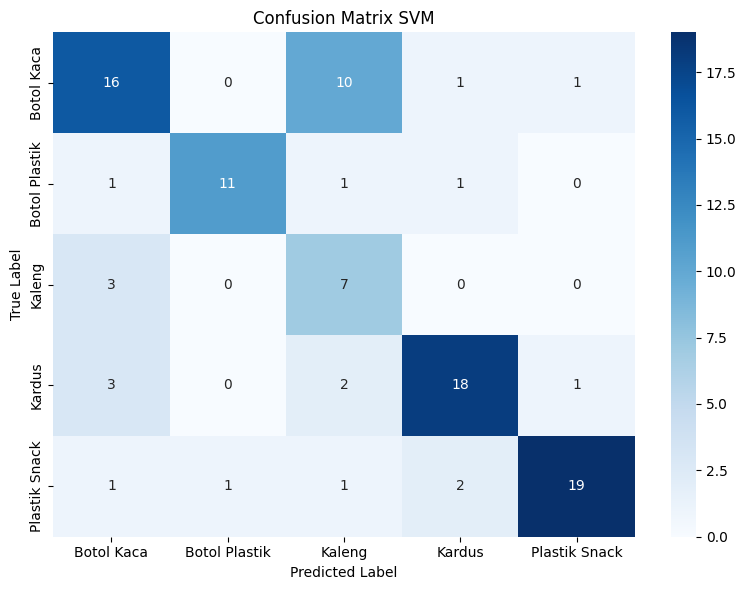

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix SVM')
plt.tight_layout()
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")


Classification Report:
               precision    recall  f1-score   support

   Botol Kaca       0.67      0.57      0.62        28
Botol Plastik       0.92      0.79      0.85        14
       Kaleng       0.33      0.70      0.45        10
       Kardus       0.82      0.75      0.78        24
Plastik Snack       0.90      0.79      0.84        24

     accuracy                           0.71       100
    macro avg       0.73      0.72      0.71       100
 weighted avg       0.76      0.71      0.73       100


Accuracy: 0.7100


#### **Hyperparameter Tuning**

In [ ]:
param_grid = {
    'kernel': ['linear', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # ddipake buat kernel='poly'
}

In [ ]:
svm = SVC()

In [ ]:
grid = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
print("Best Parameters:", grid.best_params_)
print("Best Score (CV Accuracy):", grid.best_score_)

In [ ]:
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

In [ ]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix SVM')
plt.tight_layout()
plt.show()

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")

## **Random Forest (RF)**

#### **Tanpa Tuning**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

Pisah fitur dan Label

In [ ]:
X = df.drop('category', axis=1)
y = df['category']

Split Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Prediksi

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
print("Akurasi:", accuracy_score(y_test, y_pred))
print("Laporan klasifikasi:\n", classification_report(y_test, y_pred))

Akurasi: 0.76
Laporan klasifikasi:
                precision    recall  f1-score   support

   Botol Kaca       0.74      0.71      0.73        28
Botol Plastik       0.92      0.86      0.89        14
       Kaleng       0.33      0.60      0.43        10
       Kardus       0.95      0.75      0.84        24
Plastik Snack       0.87      0.83      0.85        24

     accuracy                           0.76       100
    macro avg       0.76      0.75      0.75       100
 weighted avg       0.81      0.76      0.78       100



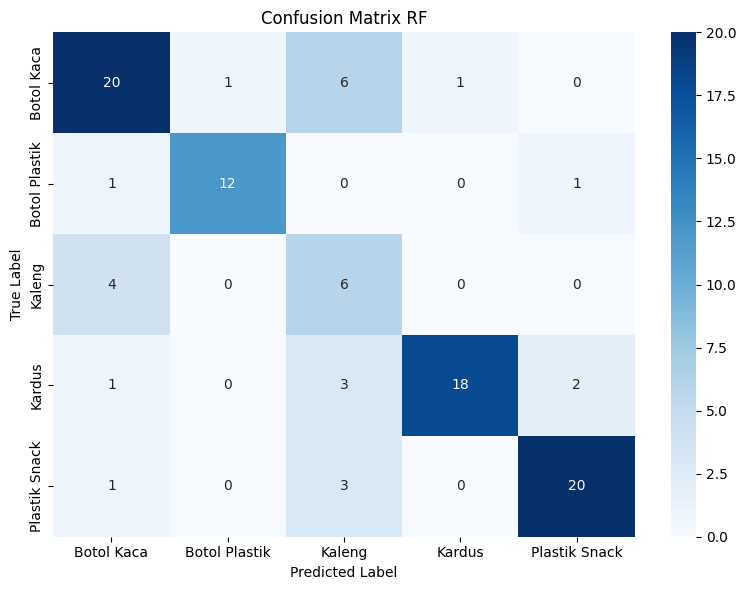

In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix RF')
plt.tight_layout()
plt.show()

#### **Hyperparameter Tuning**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100, 120, 140],
    'max_depth': [30, 35, 40]
}

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
grid_search = GridSearchCV(
    rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [30, 35, 40],
                         'n_estimators': [100, 120, 140]},
             scoring='accuracy', verbose=1)

In [ ]:
best_rf = grid_search.best_estimator_

In [ ]:
y_pred_best = best_rf.predict(X_test)

In [ ]:
print("Best Params:", grid_search.best_params_)
print("Akurasi (dengan tuning):", accuracy_score(y_test, y_pred_best))
print("Laporan klasifikasi:\n", classification_report(y_test, y_pred_best))

Best Params: {'max_depth': 30, 'n_estimators': 120}
Akurasi (dengan tuning): 0.77
Laporan klasifikasi:
                precision    recall  f1-score   support

   Botol Kaca       0.75      0.75      0.75        28
Botol Plastik       0.92      0.86      0.89        14
       Kaleng       0.35      0.60      0.44        10
       Kardus       0.95      0.75      0.84        24
Plastik Snack       0.87      0.83      0.85        24

     accuracy                           0.77       100
    macro avg       0.77      0.76      0.75       100
 weighted avg       0.81      0.77      0.78       100



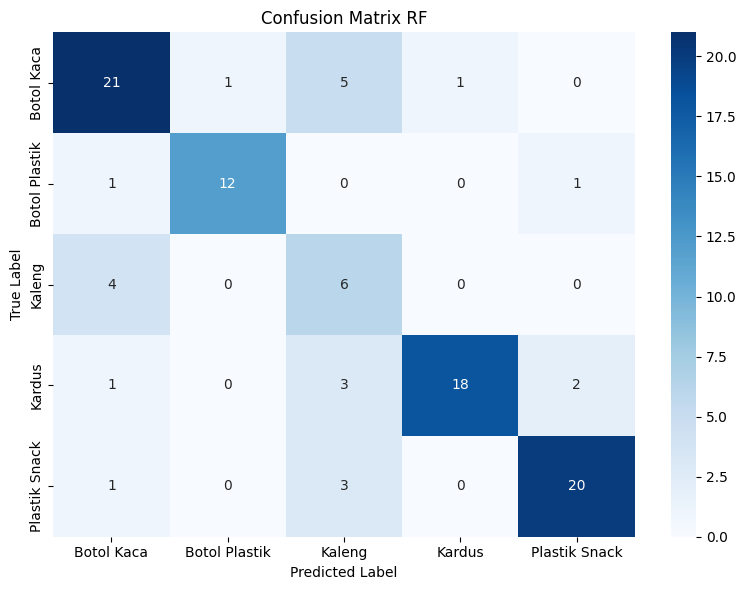

In [ ]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_rf.classes_, yticklabels=best_rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix RF')
plt.tight_layout()
plt.show()